In [62]:
import json
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
#import statsmodels.api as sm
import scipy
import statsmodels.api as sm

In [63]:
%matplotlib inline
plt.style.use('default')

In [64]:
data_dir = ".\\data"
img_dir = ".\\img"

output_links_lookup = os.path.join(data_dir, "pavement_links_to_or_links.csv")

# Paths to geometries
output_or_roads = os.path.join(data_dir, "open_roads_clean.shp")
road_nodes = os.path.join(data_dir, "open-roads RoadNode Intersect Within simplify angles.shp")
pave_nodes = os.path.join(data_dir, "pedNetworkNodes.shp")

# Paths to betweenness centrality values for each network
output_road_network = os.path.join(data_dir, "open-roads RoadLink betcen diffs.gpkg")
output_pave_links = os.path.join(data_dir, "pednetworkLinksWithCentralities.gpkg")
output_pave_ex_diag_links = os.path.join(data_dir, "pednetworkLinksExDiagWithCentralities.gpkg")
output_pave_res_links = os.path.join(data_dir, "pednetworkLinksResWithCentralities.gpkg")
output_pave_res_time_links = os.path.join(data_dir, "pednetworkLinksResTimeWithCentralities.gpkg")

# Dual betweenness centrality data
output_road_network_dual = os.path.join(data_dir, "open-roads RoadLink betcen diffs dual.gpkg")
output_pave_links_dual = os.path.join(data_dir, "dualpednetworkLinksWithCentralities.gpkg")
output_pave_ex_diag_links_dual = os.path.join(data_dir, "dualpednetworkLinksExDiagWithCentralities.gpkg")
output_pave_res_links_dual = os.path.join(data_dir, "dualpednetworkLinksResWithCentralities.gpkg")

# Output paths for figures
output_network_figure_primal = os.path.join(img_dir, "disagg_pavement_networks_primal.png")
output_network_figure_dual = os.path.join(img_dir, "disagg_pavement_networks_dual.png")

# Aggregate Centrality Comparison

## Rank Correnation - Primal Networks

Compare road centre line centrality to aggregated pavement centrality values by calculating the rank corelation between links.

Additionally, perform related sampels ttest to check for significant differences between values.

In [65]:
# Load data
gdfRoadBC = gpd.read_file(output_road_network)
gdfRoadNodes = gpd.read_file(road_nodes)
gdfPaveBC = gpd.read_file(output_pave_links)
gdfPaveExDiagBC = gpd.read_file(output_pave_ex_diag_links)
gdfPaveResBC = gpd.read_file(output_pave_res_links)

gdfPaveNodes = gpd.read_file(pave_nodes)

In [66]:
gdfRoadBC['roadBCRank'] = gdfRoadBC['roadBCsum'].rank() # RCL centrality values
gdfRoadBC['paveBCsumRank'] = gdfRoadBC['paveBCsum'].rank() # Aggreagted UPN centrality values
gdfRoadBC['paveRBCsumRank'] = gdfRoadBC['paveRBCsum'].rank() # Aggregated RUPN centrality values
gdfRoadBC['paveExDBCsumRank'] = gdfRoadBC['paveExDBCsum'].rank() # Aggregated CPN centrality values

In [125]:
# Calculate spearmna rank correlation coeff. 95% confidence intervals obtained using Fishers transform and se = 1/sqrt(n-3)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808/

data = gdfRoadBC.loc[:, ['roadBCRank', 'paveBCsumRank']].dropna().values
sr_rcl_vs_upn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
upn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_upn.correlation)-z_ci)
upn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_upn.correlation)+z_ci)

data = gdfRoadBC.loc[:, ['roadBCRank', 'paveRBCsumRank']].dropna().values
sr_rcl_vs_rupn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
rupn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_rupn.correlation)-z_ci)
rupn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_rupn.correlation)+z_ci)

data = gdfRoadBC.loc[:, ['roadBCRank', 'paveExDBCsumRank']].dropna().values
sr_rcl_vs_cpn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
cpn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_cpn.correlation)-z_ci)
cpn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_cpn.correlation)+z_ci)

In [123]:
sr_rcl_vs_upn.correlation

0.9177902891836096

In [126]:
# Print the values
print("RCL vs UPN: {}, upper {}, lower {}".format(sr_rcl_vs_upn, upn_ci_lower, upn_ci_upper))
print("RCL vs RUPN: {}, upper {}, lower {}".format(sr_rcl_vs_rupn, rupn_ci_lower, rupn_ci_upper))
print("RCL vs CPN: {}, upper {}, lower {}".format(sr_rcl_vs_cpn, cpn_ci_lower, cpn_ci_upper))

RCL vs UPN: SpearmanrResult(correlation=0.9177902891836096, pvalue=0.0), upper 0.9124552444347662, lower 0.9228133341097634
RCL vs RUPN: SpearmanrResult(correlation=0.9199488263574706, pvalue=0.0), upper 0.9147468820391135, lower 0.924845818712555
RCL vs CPN: SpearmanrResult(correlation=0.9580092191211864, pvalue=0.0), upper 0.9552224580844472, lower 0.9606260367998547


## Rank Correnation - Dual Networks

In [69]:
# Load data
gdfRoadBCDual = gpd.read_file(output_road_network_dual)
gdfPaveBCDual = gpd.read_file(output_pave_links_dual)
gdfPaveExDiagBCDual = gpd.read_file(output_pave_ex_diag_links_dual)
gdfPaveResBCDual = gpd.read_file(output_pave_res_links_dual)

In [70]:
gdfRoadBCDual['dual_roadBCRank'] = gdfRoadBCDual['dual_roadBCsum'].rank() # RCL centrality values
gdfRoadBCDual['dual_paveBCsumRank'] = gdfRoadBCDual['dual_paveBCsum'].rank() # Aggreagted UPN centrality values
gdfRoadBCDual['dual_paveRBCsumRank'] = gdfRoadBCDual['dual_paveRBCsum'].rank() # Aggregated RUPN centrality values
gdfRoadBCDual['dual_paveExDBCsumRank'] = gdfRoadBCDual['dual_paveExDBCsum'].rank() # Aggregated CPN centrality values

In [127]:
data = gdfRoadBCDual.loc[:, ['dual_roadBCRank', 'dual_paveBCsumRank']].dropna().values
sr_rcl_vs_upn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
upn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_upn.correlation)-z_ci)
upn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_upn.correlation)+z_ci)

data = gdfRoadBCDual.loc[:, ['dual_roadBCRank', 'dual_paveRBCsumRank']].dropna().values
sr_rcl_vs_rupn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
rupn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_rupn.correlation)-z_ci)
rupn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_rupn.correlation)+z_ci)

data = gdfRoadBCDual.loc[:, ['dual_roadBCRank', 'dual_paveExDBCsumRank']].dropna().values
sr_rcl_vs_cpn = scipy.stats.spearmanr(data, axis=0)
z_ci = 1.96 * (1 / np.sqrt(data.shape[0]-3))
cpn_ci_lower = np.tanh(np.arctanh(sr_rcl_vs_cpn.correlation)-z_ci)
cpn_ci_upper = np.tanh(np.arctanh(sr_rcl_vs_cpn.correlation)+z_ci)

In [129]:
# Print the values
print("Dual RCL vs UPN: {}, upper {}, lower {}".format(sr_rcl_vs_upn, upn_ci_lower, upn_ci_upper))
print("Dual RCL vs RUPN: {}, upper {}, lower {}".format(sr_rcl_vs_rupn, rupn_ci_lower, rupn_ci_upper))
print("Dual RCL vs CPN: {}, upper {}, lower {}".format(sr_rcl_vs_cpn, cpn_ci_lower, cpn_ci_upper))

Dual RCL vs UPN: SpearmanrResult(correlation=0.9413039155712954, pvalue=0.0), upper 0.9374450274717466, lower 0.9449315228353452
Dual RCL vs RUPN: SpearmanrResult(correlation=0.901809409657589, pvalue=0.0), upper 0.8954928783534852, lower 0.907762740362669
Dual RCL vs CPN: SpearmanrResult(correlation=0.9070022057816776, pvalue=0.0), upper 0.9010014672798823, lower 0.9126559251318326


# Disaggregate Centrality Comparison

## Wilcoxon signed rank test - primal

Compare the difference between a pavement links centrallity value and the mean centrality value averaged over all pavement links associated with a road link.

Use Wilcoxon signed rank test to test for significate differences between betweenness centrality difference values between pedestrian network representations. Use this test because samples are related (comparing values for the same links) and can't assume samples are normally distributed (centrality values don't follow normal distribution).

In [73]:
# Convert to numeric data type
gdfPaveBC['paveBCdiff_pv'] = gdfPaveBC['paveBCdiff_pv'].astype(float)
gdfPaveResBC['paveRBCdiff_pv'] = gdfPaveResBC['paveRBCdiff_pv'].astype(float)
gdfPaveExDiagBC['paveExDBCdiff_pv'] = gdfPaveExDiagBC['paveExDBCdiff_pv'].astype(float)

In [74]:
# Remove outliers

# There is one particularly high value in the UPN data (gdfPaveBC) for the 'paveBCdiff_pv' field. Upper quantile = 0.0022, max value = 0.11.

# Filtering out values 1.5 x higher than the top 0.9999 quantile removes this one data point.
upper_limit = gdfPaveBC['paveBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveBC.loc[ gdfPaveBC['paveBCdiff_pv']>upper_limit].index
print("UPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveBC.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveResBC['paveRBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveResBC.loc[ gdfPaveResBC['paveRBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveResBC.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveExDiagBC['paveExDBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveExDiagBC.loc[ gdfPaveExDiagBC['paveExDBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveExDiagBC.drop(index_to_drop, inplace=True)

UPN: Excluding 1 outliers
RUPN: Excluding 0 outliers
RUPN: Excluding 0 outliers


In [155]:
# just conpare pavement links
gdfPaveExDiagBCPavement = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement']
gdfPaveBCPavement = gdfPaveBC.loc[gdfPaveBC['linkType']=='pavement']
gdfPaveResBCPavement = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement']

In [162]:
data = pd.merge(gdfPaveExDiagBCPavement.loc[:, ['paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavement.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['paveExDBCdiff_pv']), abs(data['paveRBCdiff_pv']) ))
print( data['paveExDBCdiff_pv'].mean(), data['paveRBCdiff_pv'].mean())

data = pd.merge(gdfPaveBCPavement.loc[:, ['paveBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavement.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['paveBCdiff_pv']), abs(data['paveRBCdiff_pv']) ))
print( data['paveBCdiff_pv'].mean(), data['paveRBCdiff_pv'].mean())

data = pd.merge(gdfPaveBCPavement.loc[:, ['paveBCdiff_pv', 'pave_link_id']], gdfPaveExDiagBCPavement.loc[:, ['paveExDBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['paveBCdiff_pv']), abs(data['paveExDBCdiff_pv']) ))
print( data['paveBCdiff_pv'].mean(), data['paveExDBCdiff_pv'].mean())

WilcoxonResult(statistic=12260819.0, pvalue=0.0041174203196059165)
3.3579479868878723e-21 0.00011859245297311353
WilcoxonResult(statistic=10918650.5, pvalue=2.1887539517438443e-34)
0.0013255330353099369 0.00011143727127045304
WilcoxonResult(statistic=11229506.0, pvalue=3.3939932791985524e-25)
0.0012702057585244626 -5.962920119777682e-06


In [163]:
# Means
print("CPN:{} +- {}".format(abs(gdfPaveExDiagBCPavement['paveExDBCdiff_pv']).mean(), abs(gdfPaveExDiagBCPavement['paveExDBCdiff_pv']).sem()))
print("RUPN:{} +- {}".format(abs(gdfPaveResBCPavement['paveRBCdiff_pv']).mean(), abs(gdfPaveResBCPavement['paveRBCdiff_pv']).sem()))
print("UPN:{} +- {}".format(abs(gdfPaveBCPavement['paveBCdiff_pv']).mean(), abs(gdfPaveBCPavement['paveBCdiff_pv']).sem()))

CPN:0.0024391718065550493 +- 5.1025503779498126e-05
RUPN:0.002521956379149607 +- 5.2336463153636044e-05
UPN:0.0035351881957524996 +- 8.85668302190494e-05


In [164]:
# Test differences in sign of difference, ie whether bias is in same direction
# Just look for differences in direction of bias


data = pd.merge(gdfPaveExDiagBCPavement.loc[:, ['paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavement.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['paveExDBCdiff_pv']), np.sign(data['paveRBCdiff_pv']) ))

data = pd.merge(gdfPaveBCPavement.loc[:, ['paveBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavement.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['paveBCdiff_pv']), np.sign(data['paveRBCdiff_pv']) ))

data = pd.merge(gdfPaveBCPavement.loc[:, ['paveBCdiff_pv', 'pave_link_id']], gdfPaveExDiagBCPavement.loc[:, ['paveExDBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['paveBCdiff_pv']), np.sign(data['paveExDBCdiff_pv']) ))

WilcoxonResult(statistic=843068.0, pvalue=3.6278722162792293e-53)
WilcoxonResult(statistic=252597.0, pvalue=0.16909386939094573)
WilcoxonResult(statistic=1473099.0, pvalue=2.6217273653607656e-47)


## Wilcoxon signed rank test - dual

In [140]:
# Convert to numeric data type
gdfPaveBCDual['dual_paveBCdiff_pv'] = gdfPaveBCDual['dual_paveBCdiff_pv'].astype(float)
gdfPaveResBCDual['dual_paveRBCdiff_pv'] = gdfPaveResBCDual['dual_paveRBCdiff_pv'].astype(float)
gdfPaveExDiagBCDual['dual_paveExDBCdiff_pv'] = gdfPaveExDiagBCDual['dual_paveExDBCdiff_pv'].astype(float)

In [141]:
# Remove outliers

# Filtering out values 1.5 x higher than the top 0.9999 quantile removes this one data point.
upper_limit = gdfPaveBCDual['dual_paveBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveBCDual.loc[ gdfPaveBCDual['dual_paveBCdiff_pv']>upper_limit].index
print("UPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveBCDual.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveResBCDual['dual_paveRBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveResBCDual.loc[ gdfPaveResBCDual['dual_paveRBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveResBCDual.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveExDiagBCDual['dual_paveExDBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveExDiagBCDual.loc[ gdfPaveExDiagBCDual['dual_paveExDBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveExDiagBCDual.drop(index_to_drop, inplace=True)

UPN: Excluding 0 outliers
RUPN: Excluding 0 outliers
RUPN: Excluding 0 outliers


In [152]:
# Just compare pavement links
gdfPaveExDiagBCPavementDual = gdfPaveExDiagBCDual.loc[gdfPaveExDiagBCDual['linkType']=='pavement']
gdfPaveBCPavementDual = gdfPaveBCDual.loc[gdfPaveBCDual['linkType']=='pavement']
gdfPaveResBCPavementDual = gdfPaveResBCDual.loc[gdfPaveResBCDual['linkType']=='pavement']

In [153]:
# Test differences in magnitude of delta_i values

data = pd.merge(gdfPaveExDiagBCPavementDual.loc[:, ['dual_paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavementDual.loc[:, ['dual_paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['dual_paveExDBCdiff_pv']), abs(data['dual_paveRBCdiff_pv'])))
print(abs(data['dual_paveExDBCdiff_pv']).mean(), abs(data['dual_paveRBCdiff_pv']).mean())

data = pd.merge(gdfPaveBCPavementDual.loc[:, ['dual_paveBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavementDual.loc[:, ['dual_paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['dual_paveBCdiff_pv']), abs(data['dual_paveRBCdiff_pv']) ))
print(abs(data['dual_paveBCdiff_pv']).mean(), abs(data['dual_paveRBCdiff_pv']).mean())

data = pd.merge(gdfPaveBCPavementDual.loc[:, ['dual_paveBCdiff_pv', 'pave_link_id']], gdfPaveExDiagBCPavementDual.loc[:, ['dual_paveExDBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( abs(data['dual_paveBCdiff_pv']), abs(data['dual_paveExDBCdiff_pv']) ))
print(abs(data['dual_paveBCdiff_pv']).mean(), abs(data['dual_paveExDBCdiff_pv']).mean())


WilcoxonResult(statistic=7982424.0, pvalue=1.0150476572881018e-164)
0.0030115665482144897 0.002228872694095599
WilcoxonResult(statistic=8997308.0, pvalue=3.1663915659999944e-31)
0.002098661492142807 0.002223432440877663
WilcoxonResult(statistic=8399073.0, pvalue=1.686098574545994e-139)
0.00209592222085878 0.0030073198815569677


In [154]:
# Means
print("CPN:{} +- {}".format(abs(gdfPaveExDiagBCPavementDual['dual_paveExDBCdiff_pv']).mean(), abs(gdfPaveExDiagBCPavementDual['dual_paveExDBCdiff_pv']).sem()))
print("RUPN:{} +- {}".format(abs(gdfPaveResBCPavementDual['dual_paveRBCdiff_pv']).mean(), abs(gdfPaveResBCPavementDual['dual_paveRBCdiff_pv']).sem()))
print("UPN:{} +- {}".format(abs(gdfPaveBCPavementDual['dual_paveBCdiff_pv']).mean(), abs(gdfPaveBCPavementDual['dual_paveBCdiff_pv']).sem()))

CPN:0.003014405589602712 +- 8.823504594837443e-05
RUPN:0.002230238470351516 +- 7.502413649907241e-05
UPN:0.0020931737522453153 +- 6.875813732100265e-05


In [158]:
# Test differences in direction delta_i values

data = pd.merge(gdfPaveExDiagBCPavementDual.loc[:, ['dual_paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavementDual.loc[:, ['dual_paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['dual_paveExDBCdiff_pv']), np.sign(data['dual_paveRBCdiff_pv'])))

data = pd.merge(gdfPaveBCPavementDual.loc[:, ['dual_paveBCdiff_pv', 'pave_link_id']], gdfPaveResBCPavementDual.loc[:, ['dual_paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['dual_paveBCdiff_pv']), np.sign(data['dual_paveRBCdiff_pv']) ))

data = pd.merge(gdfPaveBCPavementDual.loc[:, ['dual_paveBCdiff_pv', 'pave_link_id']], gdfPaveExDiagBCPavementDual.loc[:, ['dual_paveExDBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.wilcoxon( np.sign(data['dual_paveBCdiff_pv']), np.sign(data['dual_paveExDBCdiff_pv']) ))

WilcoxonResult(statistic=718743.0, pvalue=4.141209682886416e-33)
WilcoxonResult(statistic=208418.0, pvalue=2.7820243696352673e-19)
WilcoxonResult(statistic=809399.0, pvalue=1.3622539112794166e-74)


# Plot disaggregate values

By plotting the difference between a pavement link's centrality value and the average value for that road link we can visually inspect which side of the road shortest path flows bias and see whether these biases extend for multiple road links.

## Primal Networks

In [107]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

In [115]:
def road_network_figure(G, dict_node_pos, dict_edge_values, title, cmap_name = 'viridis', edge_width = 3, edge_alpha = 1):

    plt.style.use('dark_background')
    f, ax = plt.subplots(1,1,figsize = (15,15))

    ax = road_network_subfigure(ax, G, dict_node_pos, dict_edge_values, title, cmap_name = cmap_name, edge_width=edge_width, edge_alpha=edge_alpha)
    return f

def road_network_subfigure(ax, G, dict_node_pos, title, edge_color = 'red', edge_cmap = 'bwr', edge_width = 3, edge_alpha = 1, title_font = {'size': 12}, edge_vmin = 0, edge_vmax=1):

    nx.draw_networkx_nodes(G, dict_node_pos, ax = ax, nodelist=G.nodes(), node_color = 'grey', node_size = 1, alpha = 0.1)
    nx.draw_networkx_edges(G, dict_node_pos, ax = ax, edgelist=G.edges(), width = 3, edge_color = edge_color, edge_cmap=edge_cmap, alpha=edge_alpha, edge_vmin = edge_vmin, edge_vmax=edge_vmax)
    ax.set_title(title, fontdict = title_font, y = 0)
    ax.axis('off')
    return ax

def plot_disaggregate_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiff, G_BCDiffRes, G_BCDiffExDi, BCDiff = 'paveBCdiff_pv', BCDiffRes = 'paveRBCdiff_pv', BCDiffExDi = 'paveExDBCdiff_pv', edge_alpha=1.0, cmap='bwr'):
    
    # get edge data to color edges by
    bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data(BCDiff, default=0)])
    bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data(BCDiffExDi, default=0)])
    bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data(BCDiffRes, default=0)])
    
    # bcdiff_data values excluded here because it contains a small number of large values that skew the normalisation for the colormap colormap
    all_values = np.concatenate([bcdiff_data, bcdiff_res_data, bcdiff_exdi_data])
    vmin = -1*max(abs(all_values))
    vmax = max(abs(all_values))

    f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)

    road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained\nPedestrian Network (CPN)", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained\nPedestrian Network (RUPN)", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[2], G_BCDiff, dict_node_pos, "Unconstrained\nPedestrian Network (UPN)", edge_color = bcdiff_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

    # Add rectangles indicating zoom area
    x1, y1, x2, y2 = zoom_bb
    axs[0].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
    axs[1].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
    axs[2].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))

    # Add colourbars
    smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = f.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
    cbar.ax.tick_params(labelsize=25)

    # Add inset
    axins = f.add_axes([0.27, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    axins = f.add_axes([0.25*2, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiffRes, dict_node_pos, "", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    axins = f.add_axes([0.245*3, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiff, dict_node_pos, "", edge_color = bcdiff_data, edge_cmap = plt.get_cmap(cmap), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    # Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

    _ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')
    
    return f, axs


In [86]:
# Create graphs for each network representation
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[ gdfPaveBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveBCdiff_pv']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'paveBCdiff_pv')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveExDBCdiff_pv']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'paveExDBCdiff_pv')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveRBCdiff_pv']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'paveRBCdiff_pv')

In [87]:
# Get ratio of study are height : width
study_area_bounds = gdfPaveBC.total_bounds
width = study_area_bounds[2] - study_area_bounds[0]
height = study_area_bounds[3] - study_area_bounds[1]

htow = height / width

In [88]:
# Using the geographical coordinates of the nodes when plotting them
points_pos = gdfPaveNodes.set_index('fid')
points_pos['x'] = points_pos['geometry'].map(lambda g: g.coords[0][0])
points_pos['y'] = points_pos['geometry'].map(lambda g: g.coords[0][1])
node_posistions = list(zip(points_pos['x'], points_pos['y']))
dict_node_pos = dict(zip(points_pos.index, node_posistions))

In [89]:
# Load zoom area
gdfZoom = gpd.read_file(os.path.join(data_dir, 'zoom_area2.shp'))
zoom_bb = gdfZoom.total_bounds

In [117]:
plt.style.use('default')

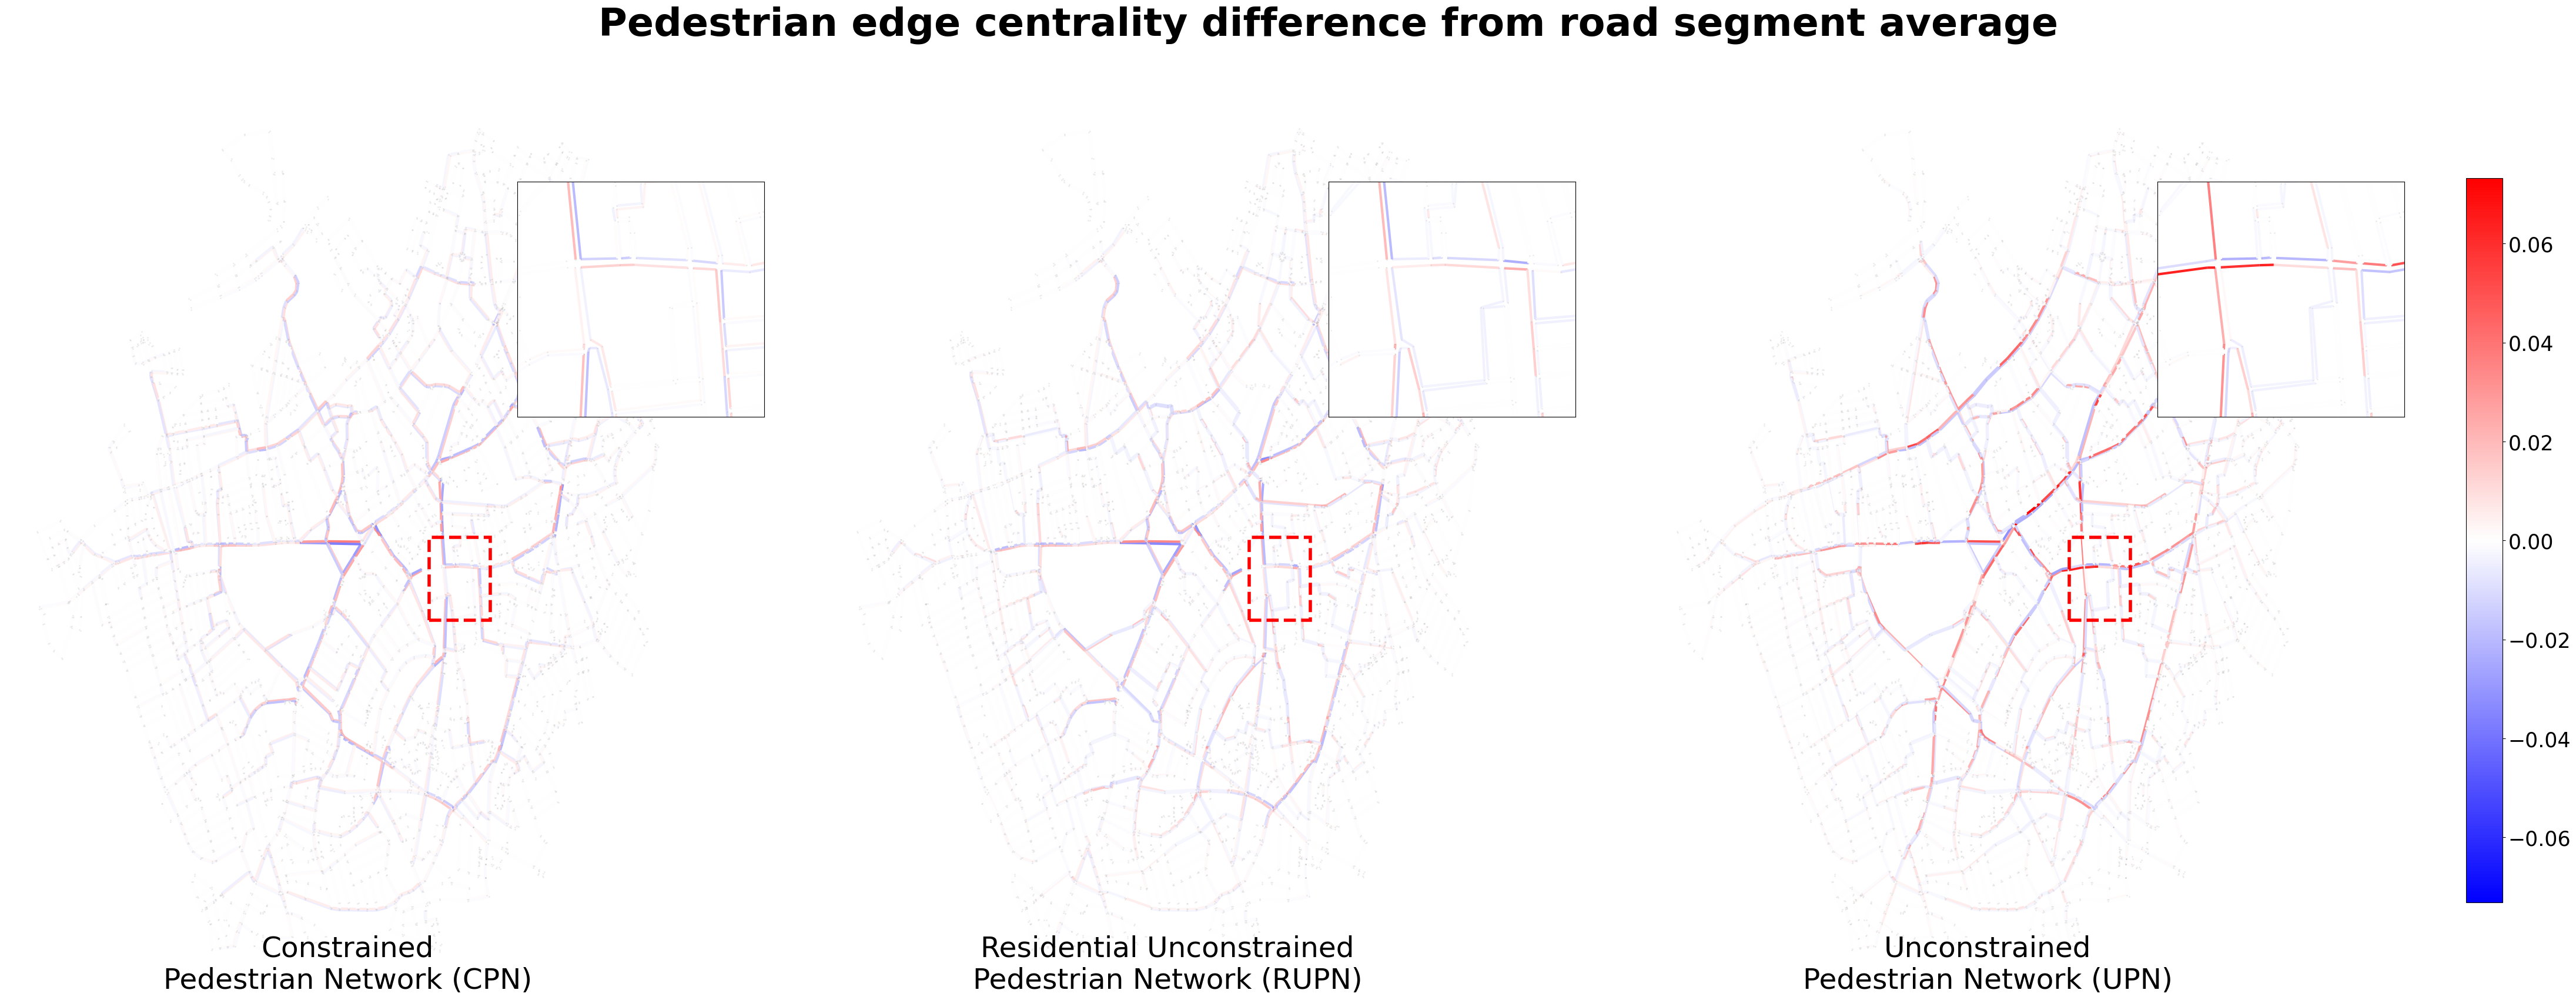

In [118]:
f, axs = plot_disaggregate_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiff, G_BCDiffRes, G_BCDiffExDi, BCDiff = 'paveBCdiff_pv', BCDiffRes = 'paveRBCdiff_pv', BCDiffExDi = 'paveExDBCdiff_pv', cmap='bwr')

In [92]:
f.savefig(output_network_figure_primal)

## Dual Networks

In [93]:
# Create graphs for each network representation
G_BCDiffDual = nx.Graph()
edges = gdfPaveBCDual.loc[ gdfPaveBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveBCdiff_pv']].dropna().values
G_BCDiffDual.add_weighted_edges_from(edges, weight = 'dual_paveBCdiff_pv')

G_BCDiffExDiDual = nx.Graph()
edges = gdfPaveExDiagBCDual.loc[gdfPaveExDiagBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveExDBCdiff_pv']].dropna().values
G_BCDiffExDiDual.add_weighted_edges_from(edges, weight = 'dual_paveExDBCdiff_pv')

G_BCDiffResDual = nx.Graph()
edges = gdfPaveResBCDual.loc[gdfPaveResBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveRBCdiff_pv']].dropna().values
G_BCDiffResDual.add_weighted_edges_from(edges, weight = 'dual_paveRBCdiff_pv')

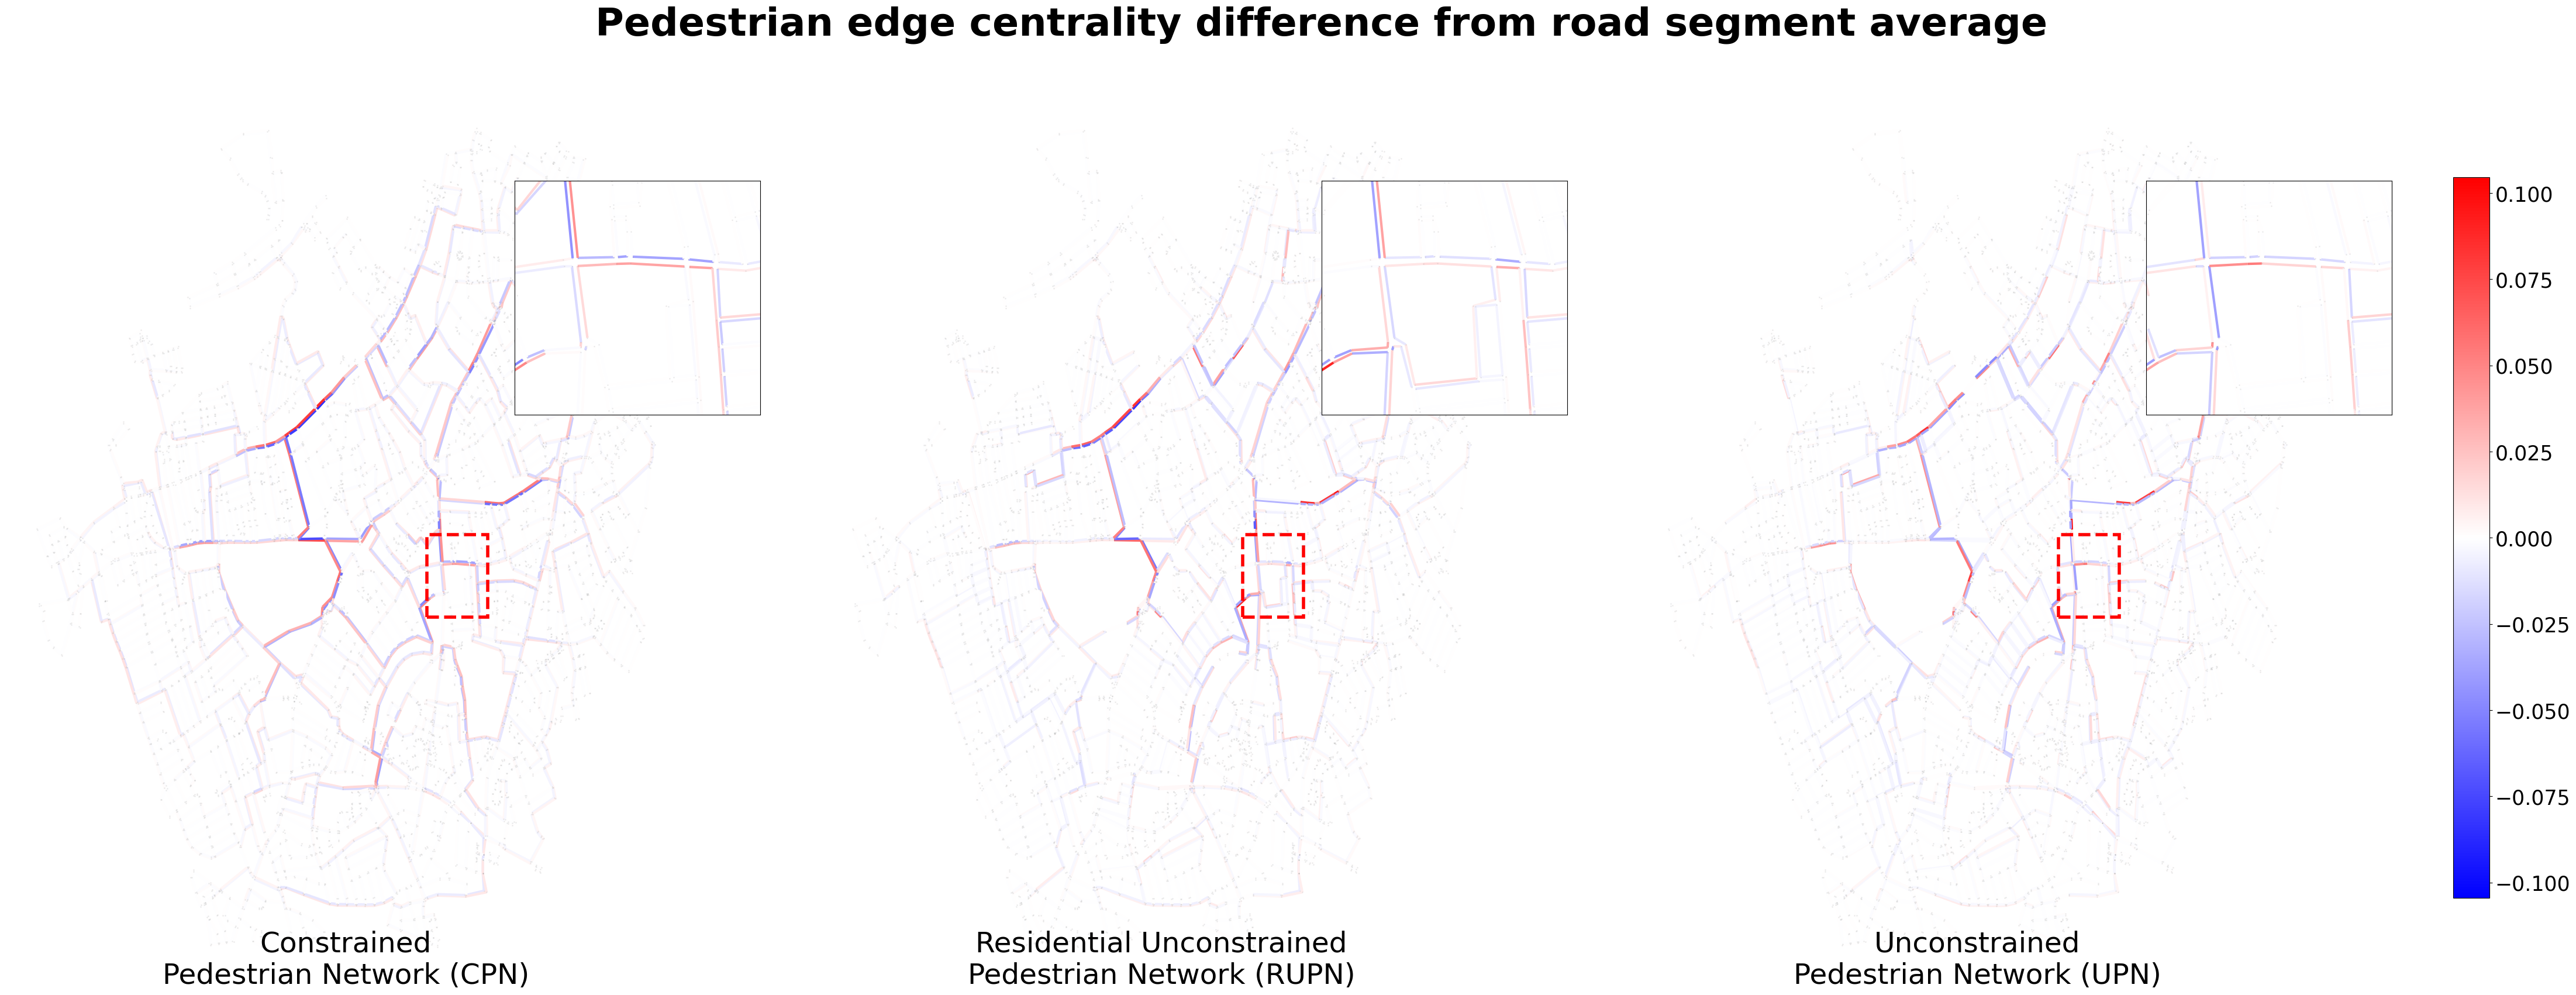

In [94]:
f, axs = plot_disaggregate_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiffDual, G_BCDiffResDual, G_BCDiffExDiDual, BCDiff = 'dual_paveBCdiff_pv', BCDiffRes = 'dual_paveRBCdiff_pv', BCDiffExDi = 'dual_paveExDBCdiff_pv')

In [95]:
f.savefig(output_network_figure_dual)

# Plot BC values as a check

In [96]:
def plot_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiff, G_BCDiffRes, G_BCDiffExDi, BCDiff = 'paveBCdiff_pv', BCDiffRes = 'paveRBCdiff_pv', BCDiffExDi = 'paveExDBCdiff_pv', edge_alpha=1.0):
    
    # get edge data to color edges by
    bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data(BCDiff, default=0)])
    bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data(BCDiffExDi, default=0)])
    bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data(BCDiffRes, default=0)])
    
    # bcdiff_data values excluded here because it contains a small number of large values that skew the normalisation for the colormap colormap
    all_values = np.concatenate([bcdiff_data, bcdiff_res_data, bcdiff_exdi_data])
    vmin = 0.0
    vmax = max(abs(all_values))

    f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)

    road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained\nPedestrian Network (CPN)", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('viridis'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained\nPedestrian Network (RUPN)", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('viridis'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[2], G_BCDiff, dict_node_pos, "Unconstrained\nPedestrian Network (UPN)", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('viridis'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

    # Add colourbars
    smap = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = f.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
    cbar.ax.tick_params(labelsize=25)

    # Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

    _ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')
    
    return f, axs

## Primal networks

In [97]:
# Create graphs for each network representation
G_BC = nx.Graph()
edges = gdfPaveBC.loc[ gdfPaveBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveBCnorm']].dropna().values
G_BC.add_weighted_edges_from(edges, weight = 'paveBCnorm')

G_BCExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveExDBCnorm']].dropna().values
G_BCExDi.add_weighted_edges_from(edges, weight = 'paveExDBCnorm')

G_BCRes = nx.Graph()
edges = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveRBCnorm']].dropna().values
G_BCRes.add_weighted_edges_from(edges, weight = 'paveRBCnorm')

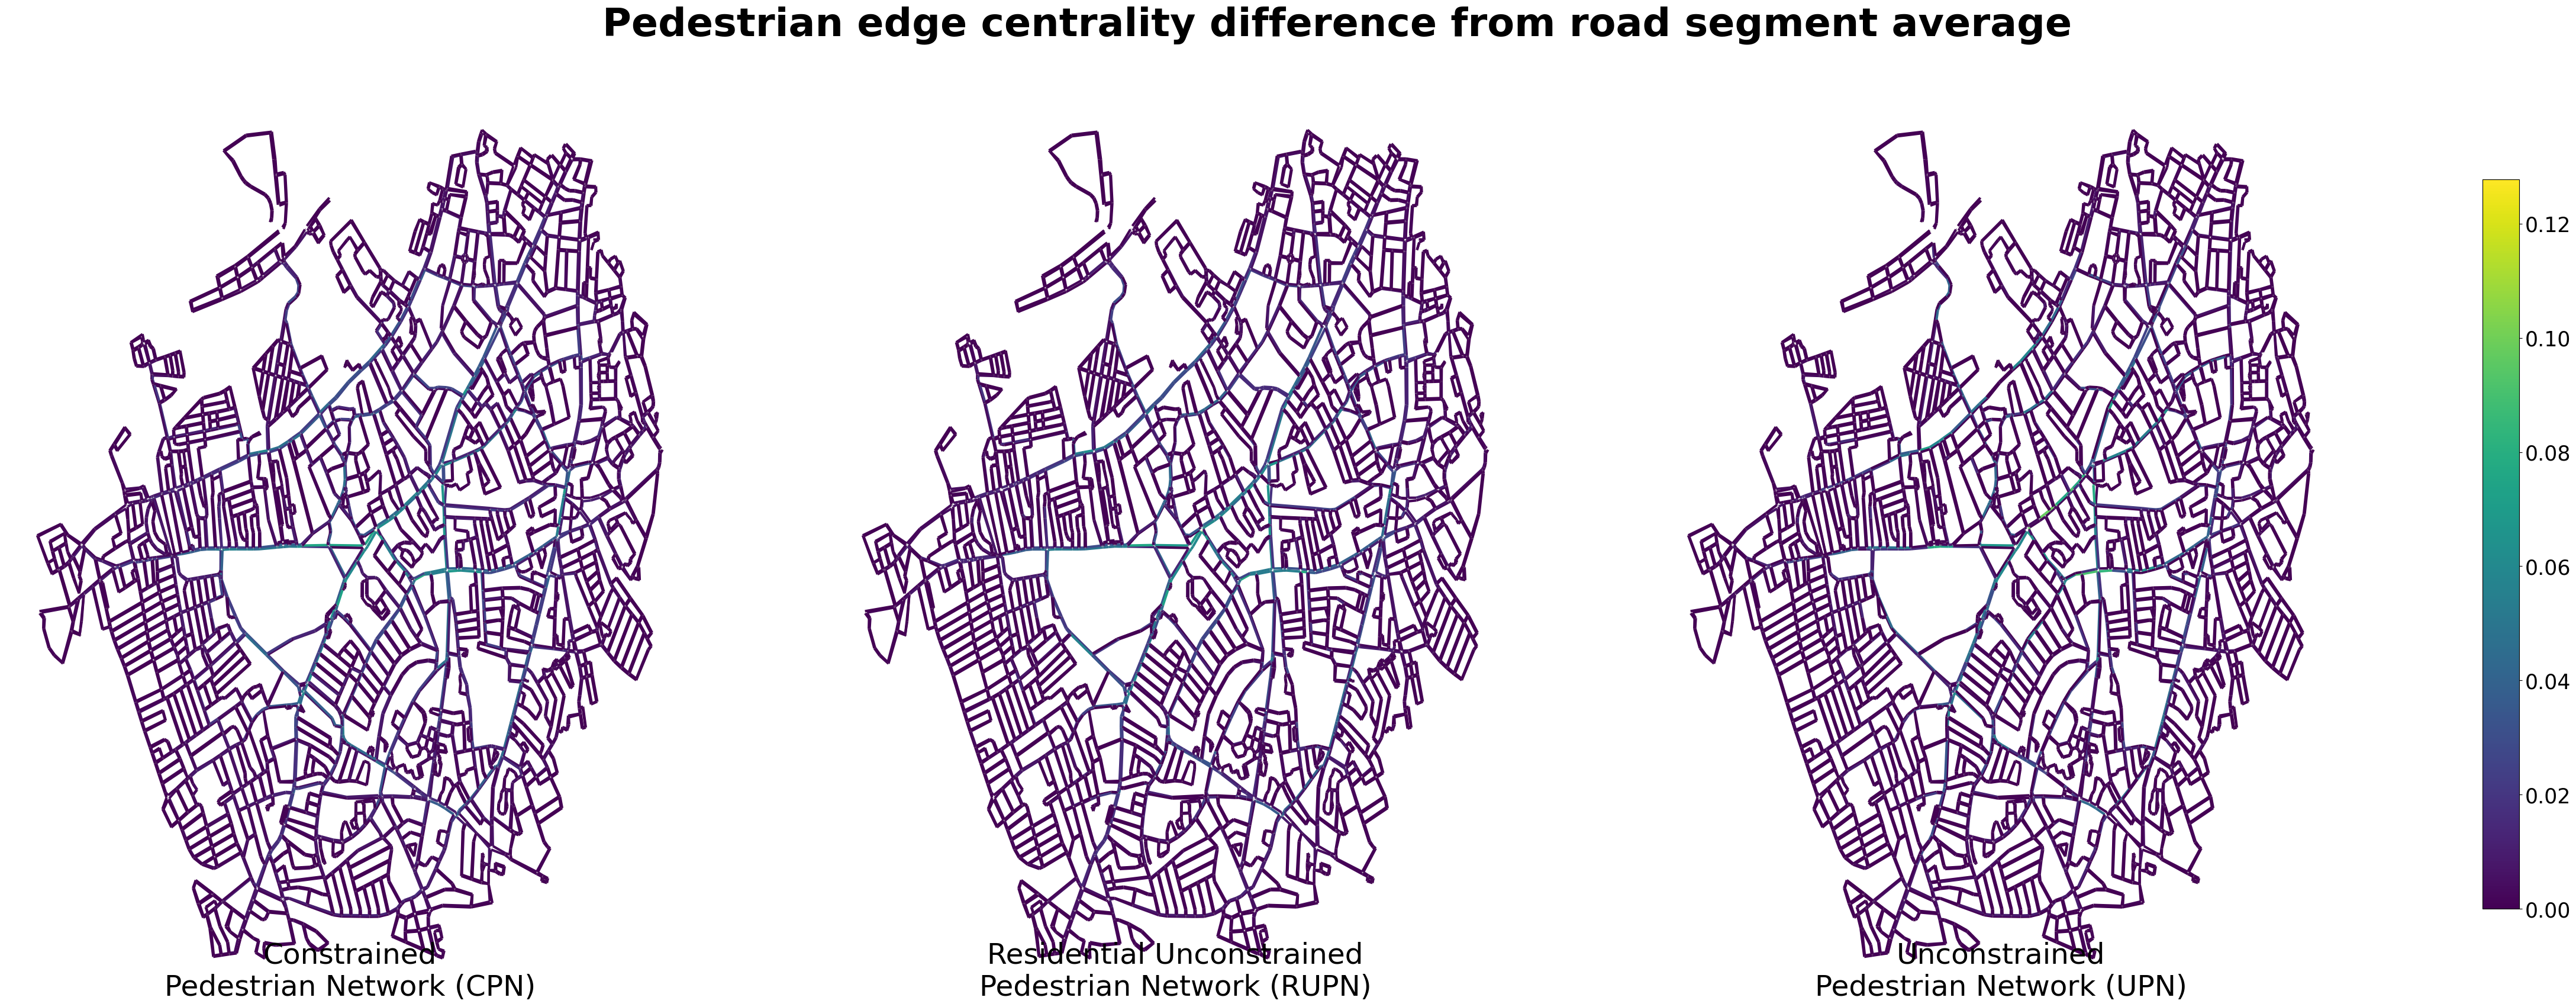

In [98]:
f, axs = plot_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BC, G_BCRes, G_BCExDi, BCDiff = 'paveBCnorm', BCDiffRes = 'paveRBCnorm', BCDiffExDi = 'paveExDBCnorm')

## Dual networks

In [99]:
# Create graphs for each network representation
G_BCDual = nx.Graph()
edges = gdfPaveBCDual.loc[ gdfPaveBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveBCnorm']].dropna().values
G_BCDual.add_weighted_edges_from(edges, weight = 'dual_paveBCnorm')

G_BCExDiDual = nx.Graph()
edges = gdfPaveExDiagBCDual.loc[gdfPaveExDiagBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveExDBCnorm']].dropna().values
G_BCExDiDual.add_weighted_edges_from(edges, weight = 'dual_paveExDBCnorm')

G_BCResDual = nx.Graph()
edges = gdfPaveResBCDual.loc[gdfPaveResBCDual['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'dual_paveRBCnorm']].dropna().values
G_BCResDual.add_weighted_edges_from(edges, weight = 'dual_paveRBCnorm')

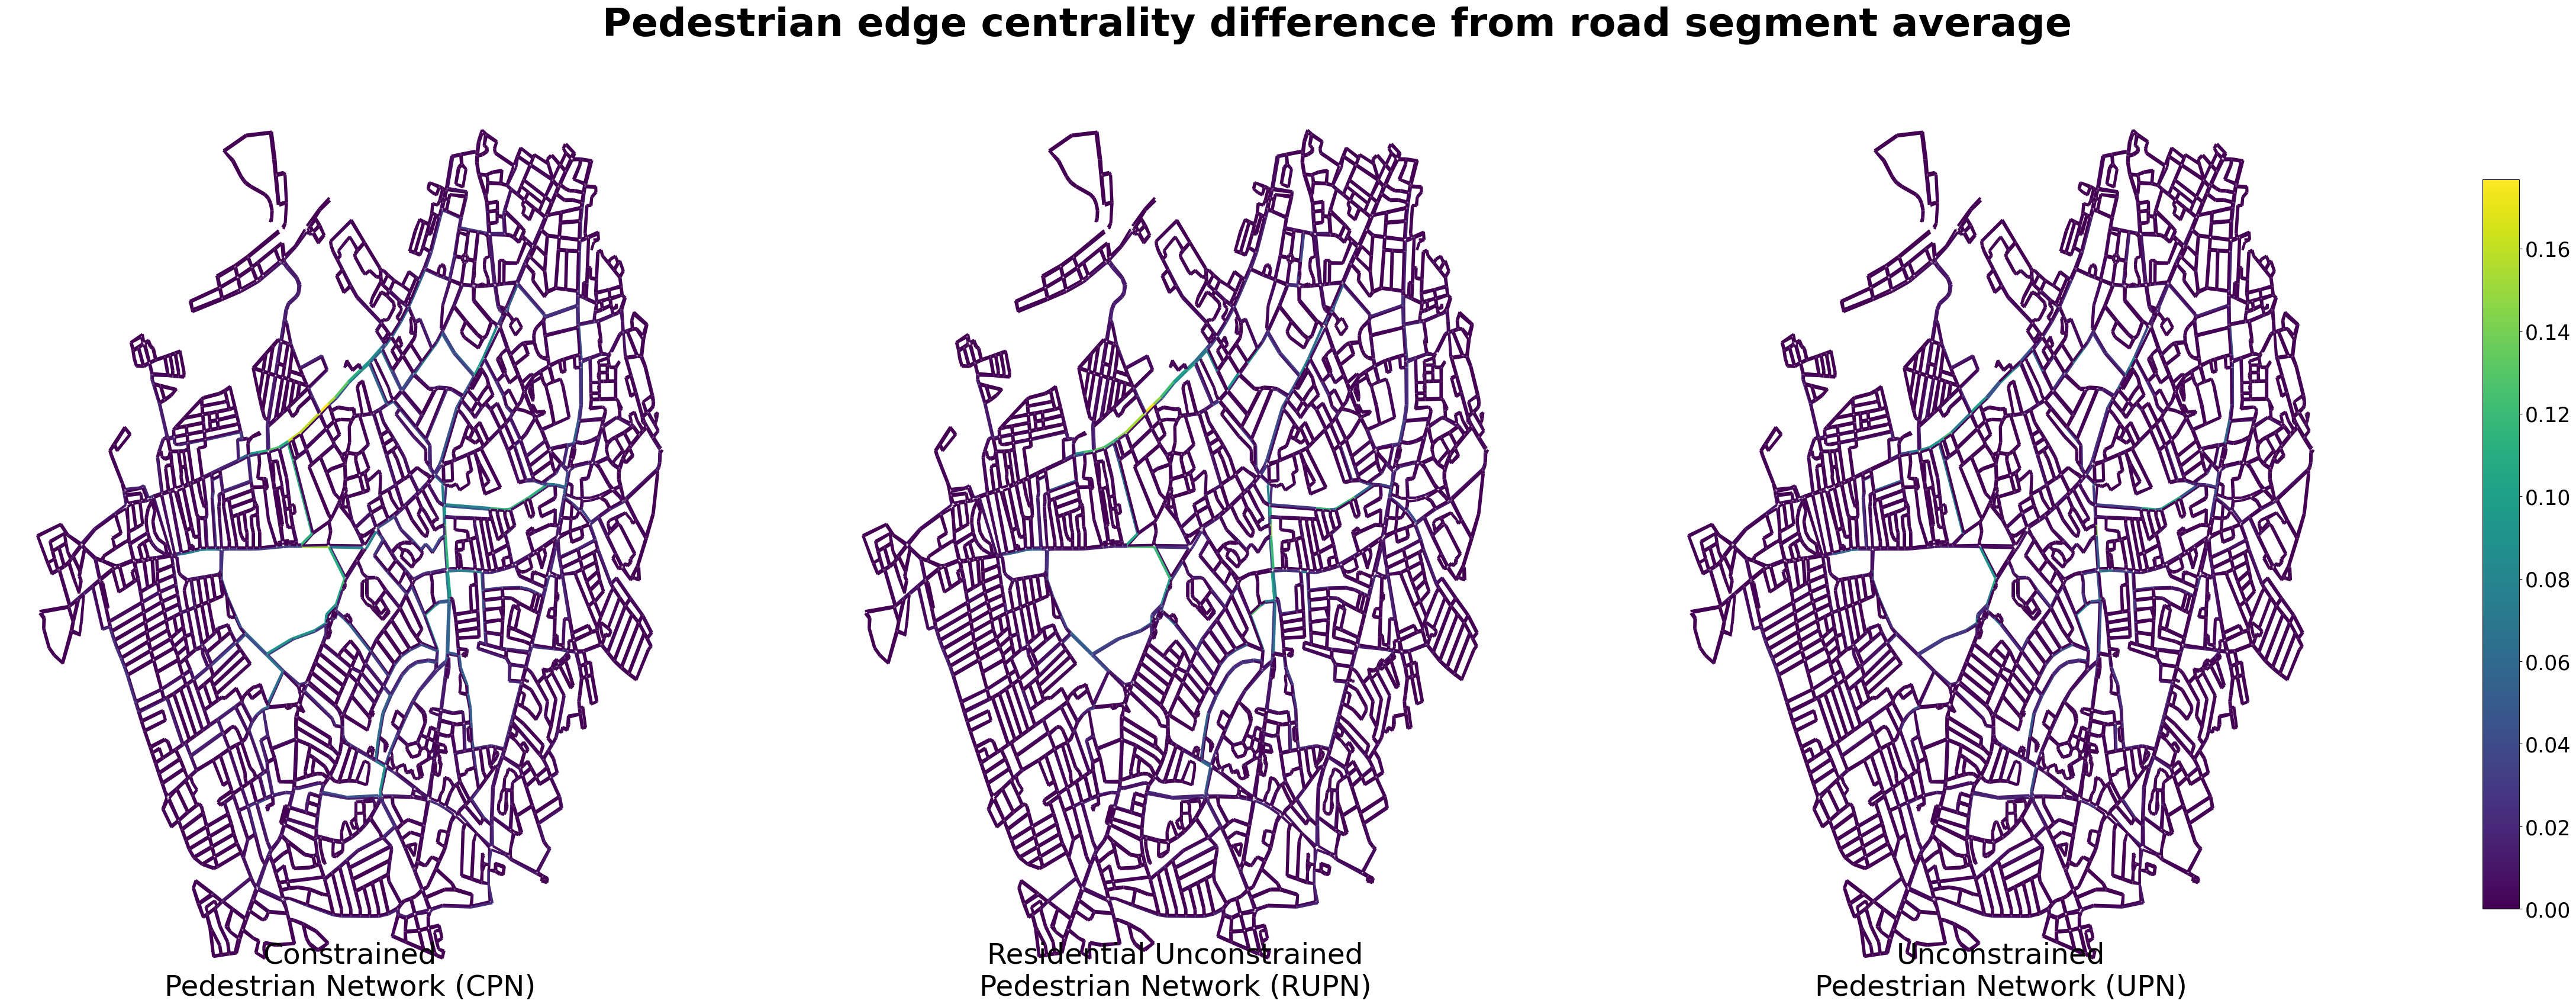

In [100]:
f, axs = plot_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDual, G_BCResDual, G_BCExDiDual, BCDiff = 'dual_paveBCnorm', BCDiffRes = 'dual_paveRBCnorm', BCDiffExDi = 'dual_paveExDBCnorm')